In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
director_coremetrics = pd.read_excel('BS_AllCompanies_Overview_March2023update.xlsx', sheet_name='DIRECTOR_COREMETRICS')
company_coremetrics = pd.read_excel('BS_AllCompanies_Overview_March2023update.xlsx', sheet_name='COMPANY_COREMETRICS')
dir_comp_coremetrics = pd.read_excel('BS_AllCompanies_Overview_March2023update.xlsx', sheet_name='DIRECTOR_COMPANY_COREMETRICS')

In [44]:
filt = ((dir_comp_coremetrics['DIRECTOR: GENDER'] == 'Not Stated') | (dir_comp_coremetrics['DIRECTOR: GENDER'].isnull()))
# Cleaning Gender Variable
cleaned_dir_comp = dir_comp_coremetrics[~ filt].copy()

# Imputing Age
cleaned_dir_comp['DIRECTOR: AGE'] = cleaned_dir_comp['DIRECTOR: AGE'].fillna(cleaned_dir_comp['DIRECTOR: AGE'].mean())

# Fixing the performance columns
perf_cols = ['PERFORMANCE: WIN RATE', 'PERFORMANCE: EBITDA WIN RATE', 'PERFORMANCE: TSR WIN RATE', 'PERFORMANCE: CARBON INTENSITY WIN RATE', 'PERFORMANCE: CONTROVERSY WIN RATE']
for col in perf_cols:
    cleaned_dir_comp.loc[cleaned_dir_comp[col] == 'Unrated', col] = 0
cleaned_dir_comp[perf_cols] = cleaned_dir_comp[perf_cols].astype('float64')

# Creating Average Influence out of 5 years of influence
cleaned_dir_comp['AVG_INFLUENCE'] = cleaned_dir_comp[['INFLUENCE:2023','INFLUENCE:2022','INFLUENCE:2021','INFLUENCE:2020','INFLUENCE:2019','INFLUENCE:2018']].mean(axis=1,skipna=True).round(2)

In [45]:
cleaned_dir_comp.columns

Index(['DIRECTOR: ID', 'DIRECTOR: NAME', 'DIRECTOR: AGE', 'DIRECTOR: GENDER',
       'DIRECTOR: DIVERSITY', 'DIRECTOR: ACTIVE BOARDS',
       'DIRECTOR: BOARD HISTORY', 'COMPANY: NAME', 'COMPANY: TICKER',
       'COMPANY: CUSIP', 'COMPANY: DOMICILE', 'COMPANY: SECTOR',
       'COMPANY: LEAGUE', 'COMPANY: ACTIVE DIRECTORS',
       'COMPANY: ALL DIRECTORS', 'INFLUENCE: MRY', 'INFLUENCE:2023',
       'INFLUENCE:2022', 'INFLUENCE:2021', 'INFLUENCE:2020', 'INFLUENCE:2019',
       'INFLUENCE:2018', 'INFLUENCE DRIVER: ADVANCED DEGREE',
       'INFLUENCE DRIVER: ELITE SCHOOL', 'INFLUENCE DRIVER: HAS BEEN CEO',
       'INFLUENCE DRIVER: FOUNDER-CEO-FAMILY', 'INFLUENCE DRIVER: CHAIR ROLE',
       'INFLUENCE DRIVER: COMMITTEE ROLE',
       'INFLUENCE DRIVER: BOARD CONNECTIONS',
       'INFLUENCE DRIVER: STRUCTURAL ADVANTAGE', 'PERFORMANCE: WIN RATE',
       'PERFORMANCE: EBITDA WIN RATE', 'PERFORMANCE: TSR WIN RATE',
       'PERFORMANCE: CARBON INTENSITY WIN RATE',
       'PERFORMANCE: CONTROVERS

In [46]:
# Mapping numeric values to binary values
conv_cols = ['INFLUENCE DRIVER: ADVANCED DEGREE', 'INFLUENCE DRIVER: ELITE SCHOOL', 'INFLUENCE DRIVER: HAS BEEN CEO',
       'INFLUENCE DRIVER: FOUNDER-CEO-FAMILY', 'INFLUENCE DRIVER: CHAIR ROLE', 'INFLUENCE DRIVER: COMMITTEE ROLE',
       'INFLUENCE DRIVER: BOARD CONNECTIONS', 'INFLUENCE DRIVER: STRUCTURAL ADVANTAGE']
for col in conv_cols:
    cleaned_dir_comp[col] = cleaned_dir_comp[col].map({'Yes':1, 'No':0})

# Dropping the columns that are not needed
cleaned_dir_comp = cleaned_dir_comp.drop(['DIRECTOR: DIVERSITY','COMPANY: CUSIP'], axis=1)

In [47]:
cleaned_dir_comp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86531 entries, 0 to 86771
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   DIRECTOR: ID                            86531 non-null  int64  
 1   DIRECTOR: NAME                          86531 non-null  object 
 2   DIRECTOR: AGE                           86531 non-null  float64
 3   DIRECTOR: GENDER                        86531 non-null  object 
 4   DIRECTOR: ACTIVE BOARDS                 86531 non-null  int64  
 5   DIRECTOR: BOARD HISTORY                 86531 non-null  int64  
 6   COMPANY: NAME                           86531 non-null  object 
 7   COMPANY: TICKER                         86468 non-null  object 
 8   COMPANY: DOMICILE                       86531 non-null  object 
 9   COMPANY: SECTOR                         86025 non-null  object 
 10  COMPANY: LEAGUE                         86531 non-null  in

In [56]:
perf_by_league = cleaned_dir_comp.groupby(['COMPANY: LEAGUE']).agg({'PERFORMANCE: EBITDA WIN RATE': 'mean', 
                                                   'PERFORMANCE: TSR WIN RATE': 'mean', 
                                                   'PERFORMANCE: CARBON INTENSITY WIN RATE': 'mean', 
                                                   'PERFORMANCE: CONTROVERSY WIN RATE': 'mean', }).reset_index()
perf_by_league['COMPANY: LEAGUE'] = perf_by_league['COMPANY: LEAGUE'].astype('category')

perf_by_league

,COMPANY: LEAGUE,PERFORMANCE: EBITDA WIN RATE,PERFORMANCE: TSR WIN RATE,PERFORMANCE: CARBON INTENSITY WIN RATE,PERFORMANCE: CONTROVERSY WIN RATE
0,1,0.258455,0.213150,0.199993,0.566533
1,2,0.288728,0.255898,0.240224,0.560601
2,3,0.311265,0.286175,0.278707,0.448534
3,4,0.515012,0.365162,0.355232,0.144272


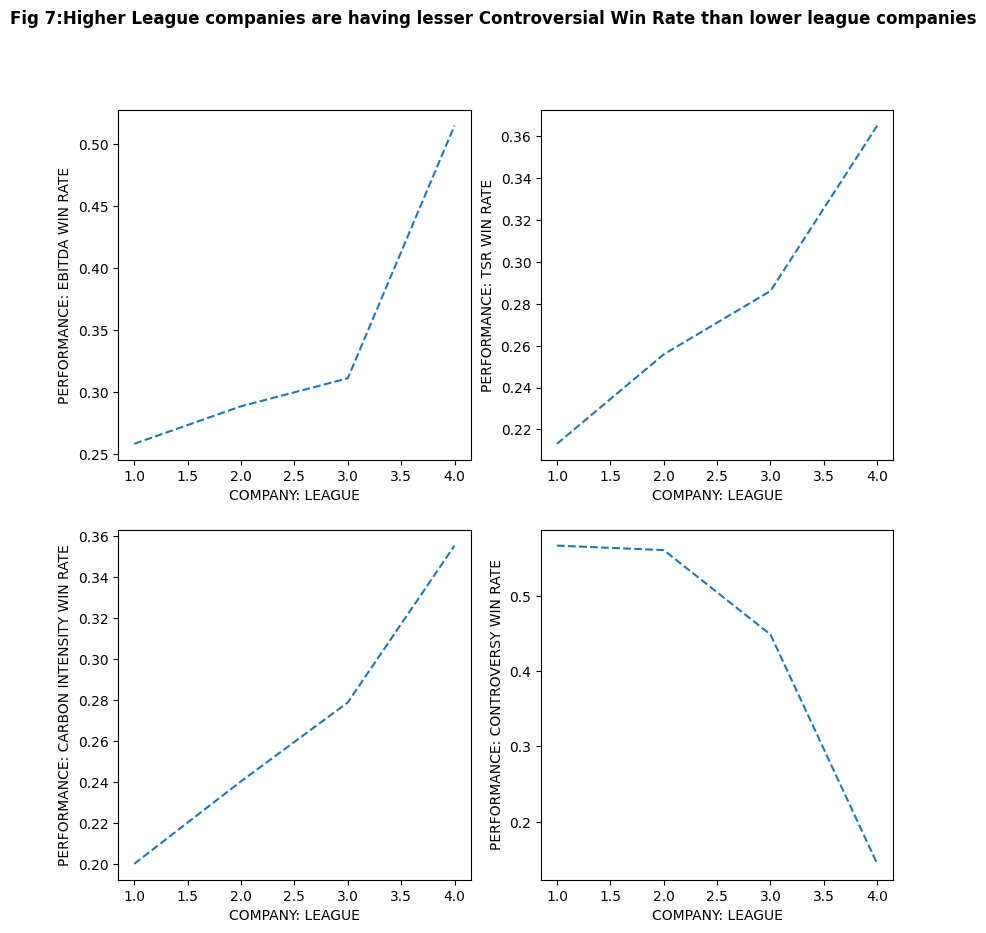

In [198]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.lineplot(ax=axes[0,0], x='COMPANY: LEAGUE', y='PERFORMANCE: EBITDA WIN RATE', data=perf_by_league, linestyle='--')
sns.lineplot(ax=axes[0,1], x='COMPANY: LEAGUE', y='PERFORMANCE: TSR WIN RATE', data=perf_by_league, linestyle='--')
sns.lineplot(ax=axes[1,0], x='COMPANY: LEAGUE', y='PERFORMANCE: CARBON INTENSITY WIN RATE', data=perf_by_league, linestyle='--')
sns.lineplot(ax=axes[1,1], x='COMPANY: LEAGUE', y='PERFORMANCE: CONTROVERSY WIN RATE', data=perf_by_league, linestyle='--')

plt.suptitle('Fig 7:Higher League companies are having lesser Controversial Win Rate than lower league companies', fontweight='bold')
plt.show()

## Overall Win Rate Analysis

In [77]:
win_rate_removed = cleaned_dir_comp[~ (cleaned_dir_comp['PERFORMANCE: EBITDA WIN RATE'] == 0)]

In [78]:
win_rate_removed

,DIRECTOR: ID,DIRECTOR: NAME,DIRECTOR: AGE,DIRECTOR: GENDER,DIRECTOR: ACTIVE BOARDS,DIRECTOR: BOARD HISTORY,COMPANY: NAME,COMPANY: TICKER,COMPANY: DOMICILE,COMPANY: SECTOR,COMPANY: LEAGUE,COMPANY: ACTIVE DIRECTORS,COMPANY: ALL DIRECTORS,INFLUENCE: MRY,INFLUENCE:2023,INFLUENCE:2022,INFLUENCE:2021,INFLUENCE:2020,INFLUENCE:2019,INFLUENCE:2018,INFLUENCE DRIVER: ADVANCED DEGREE,INFLUENCE DRIVER: ELITE SCHOOL,INFLUENCE DRIVER: HAS BEEN CEO,INFLUENCE DRIVER: FOUNDER-CEO-FAMILY,INFLUENCE DRIVER: CHAIR ROLE,INFLUENCE DRIVER: COMMITTEE ROLE,INFLUENCE DRIVER: BOARD CONNECTIONS,INFLUENCE DRIVER: STRUCTURAL ADVANTAGE,PERFORMANCE: WIN RATE,PERFORMANCE: EBITDA WIN RATE,PERFORMANCE: TSR WIN RATE,PERFORMANCE: CARBON INTENSITY WIN RATE,PERFORMANCE: CONTROVERSY WIN RATE,AVG_INFLUENCE
1,554436,Celia Brown,68.0,Female,1,1,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,3.5,3.5,3.5,3.4,3.1,3.0,3.0,1,0,1,0,1,1,0,0,0.616,0.312,0.521,0.819,1.000,3.25
2,108789,Christopher McCann,61.0,Male,1,1,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,12.0,12.0,12.0,11.9,11.9,12.2,12.2,0,0,1,1,0,0,0,1,0.618,0.315,0.536,0.817,1.000,12.03
4,175585,Eugene DeMark,75.0,Male,1,2,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,2.0,2.0,2.0,1.9,1.9,1.8,1.8,1,0,0,0,1,1,0,0,0.618,0.314,0.529,0.818,1.000,1.90
5,130106,James Cannavino,78.0,Male,1,1,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,1.6,1.6,1.6,1.5,2.0,2.0,2.0,0,0,1,0,1,1,0,0,0.625,0.321,0.563,0.815,1.000,1.78
6,22002,James McCann,71.0,Male,2,4,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,71.1,71.1,71.1,71.0,71.0,71.6,71.6,0,0,1,1,0,0,0,1,0.619,0.315,0.536,0.817,1.000,71.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86759,596241,Tarun Arora,50.0,Male,1,1,ZYDUS WELLNESS LIMITED,ZYDUSWELL,IN,Consumer Staples,1,8,8,11.1,11.1,11.1,10.6,10.6,NaN,NaN,1,0,1,1,0,0,0,0,0.539,0.800,0.456,0.274,0.532,10.85
86768,232433,Barry Michaels,72.0,Male,1,1,Zynex Inc,ZYXI,US,Health Care,1,4,4,18.2,18.2,18.2,18.2,18.2,NaN,NaN,1,0,1,0,1,1,0,0,0.807,0.692,0.690,0.806,1.000,18.20
86769,232874,Joshua Disbrow,47.0,Male,1,1,Zynex Inc,ZYXI,US,Health Care,1,4,4,16.8,16.8,16.8,16.8,16.8,NaN,NaN,0,0,1,0,1,1,0,0,0.807,0.692,0.690,0.806,1.000,16.80
86770,638372,Michael Cress,64.0,Male,1,1,Zynex Inc,ZYXI,US,Health Care,1,4,4,18.2,18.2,18.2,18.2,18.2,NaN,NaN,1,0,1,0,1,1,0,0,0.807,0.692,0.690,0.806,1.000,18.20


In [79]:
win_rate_enc = pd.get_dummies(win_rate_removed, columns=['DIRECTOR: GENDER', 'COMPANY: SECTOR'])

In [80]:
win_rate_enc.columns

Index(['DIRECTOR: ID', 'DIRECTOR: NAME', 'DIRECTOR: AGE',
       'DIRECTOR: ACTIVE BOARDS', 'DIRECTOR: BOARD HISTORY', 'COMPANY: NAME',
       'COMPANY: TICKER', 'COMPANY: DOMICILE', 'COMPANY: LEAGUE',
       'COMPANY: ACTIVE DIRECTORS', 'COMPANY: ALL DIRECTORS', 'INFLUENCE: MRY',
       'INFLUENCE:2023', 'INFLUENCE:2022', 'INFLUENCE:2021', 'INFLUENCE:2020',
       'INFLUENCE:2019', 'INFLUENCE:2018', 'INFLUENCE DRIVER: ADVANCED DEGREE',
       'INFLUENCE DRIVER: ELITE SCHOOL', 'INFLUENCE DRIVER: HAS BEEN CEO',
       'INFLUENCE DRIVER: FOUNDER-CEO-FAMILY', 'INFLUENCE DRIVER: CHAIR ROLE',
       'INFLUENCE DRIVER: COMMITTEE ROLE',
       'INFLUENCE DRIVER: BOARD CONNECTIONS',
       'INFLUENCE DRIVER: STRUCTURAL ADVANTAGE', 'PERFORMANCE: WIN RATE',
       'PERFORMANCE: EBITDA WIN RATE', 'PERFORMANCE: TSR WIN RATE',
       'PERFORMANCE: CARBON INTENSITY WIN RATE',
       'PERFORMANCE: CONTROVERSY WIN RATE', 'AVG_INFLUENCE',
       'DIRECTOR: GENDER_Female', 'DIRECTOR: GENDER_Male',
     

In [81]:
cols_kept = ['DIRECTOR: AGE','DIRECTOR: ACTIVE BOARDS', 'DIRECTOR: BOARD HISTORY','COMPANY: LEAGUE','COMPANY: ACTIVE DIRECTORS', 'INFLUENCE DRIVER: ADVANCED DEGREE',
       'INFLUENCE DRIVER: ELITE SCHOOL', 'INFLUENCE DRIVER: HAS BEEN CEO', 'INFLUENCE DRIVER: FOUNDER-CEO-FAMILY', 'INFLUENCE DRIVER: CHAIR ROLE',
       'INFLUENCE DRIVER: COMMITTEE ROLE', 'INFLUENCE DRIVER: BOARD CONNECTIONS', 'INFLUENCE DRIVER: STRUCTURAL ADVANTAGE', 'PERFORMANCE: EBITDA WIN RATE',
       'AVG_INFLUENCE', 'DIRECTOR: GENDER_Female', 'DIRECTOR: GENDER_Male']
win_rate_df = win_rate_enc[cols_kept].copy()
win_rate_df['PERFORMANCE: EBITDA WIN RATE'] = win_rate_df['PERFORMANCE: EBITDA WIN RATE'].astype('float64')

In [82]:
win_rate_df

,DIRECTOR: AGE,DIRECTOR: ACTIVE BOARDS,DIRECTOR: BOARD HISTORY,COMPANY: LEAGUE,COMPANY: ACTIVE DIRECTORS,INFLUENCE DRIVER: ADVANCED DEGREE,INFLUENCE DRIVER: ELITE SCHOOL,INFLUENCE DRIVER: HAS BEEN CEO,INFLUENCE DRIVER: FOUNDER-CEO-FAMILY,INFLUENCE DRIVER: CHAIR ROLE,INFLUENCE DRIVER: COMMITTEE ROLE,INFLUENCE DRIVER: BOARD CONNECTIONS,INFLUENCE DRIVER: STRUCTURAL ADVANTAGE,PERFORMANCE: EBITDA WIN RATE,AVG_INFLUENCE,DIRECTOR: GENDER_Female,DIRECTOR: GENDER_Male
1,68.0,1,1,1,11,1,0,1,0,1,1,0,0,0.312,3.25,1,0
2,61.0,1,1,1,11,0,0,1,1,0,0,0,1,0.315,12.03,0,1
4,75.0,1,2,1,11,1,0,0,0,1,1,0,0,0.314,1.90,0,1
5,78.0,1,1,1,11,0,0,1,0,1,1,0,0,0.321,1.78,0,1
6,71.0,2,4,1,11,0,0,1,1,0,0,0,1,0.315,71.23,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86759,50.0,1,1,1,8,1,0,1,1,0,0,0,0,0.800,10.85,0,1
86768,72.0,1,1,1,4,1,0,1,0,1,1,0,0,0.692,18.20,0,1
86769,47.0,1,1,1,4,0,0,1,0,1,1,0,0,0.692,16.80,0,1
86770,64.0,1,1,1,4,1,0,1,0,1,1,0,0,0.692,18.20,0,1


In [83]:
win_rate_df.columns

Index(['DIRECTOR: AGE', 'DIRECTOR: ACTIVE BOARDS', 'DIRECTOR: BOARD HISTORY',
       'COMPANY: LEAGUE', 'COMPANY: ACTIVE DIRECTORS',
       'INFLUENCE DRIVER: ADVANCED DEGREE', 'INFLUENCE DRIVER: ELITE SCHOOL',
       'INFLUENCE DRIVER: HAS BEEN CEO',
       'INFLUENCE DRIVER: FOUNDER-CEO-FAMILY', 'INFLUENCE DRIVER: CHAIR ROLE',
       'INFLUENCE DRIVER: COMMITTEE ROLE',
       'INFLUENCE DRIVER: BOARD CONNECTIONS',
       'INFLUENCE DRIVER: STRUCTURAL ADVANTAGE',
       'PERFORMANCE: EBITDA WIN RATE', 'AVG_INFLUENCE',
       'DIRECTOR: GENDER_Female', 'DIRECTOR: GENDER_Male'],
      dtype='object')

Text(0.5, 1.0, 'Fig 1: Correlation Matrix')

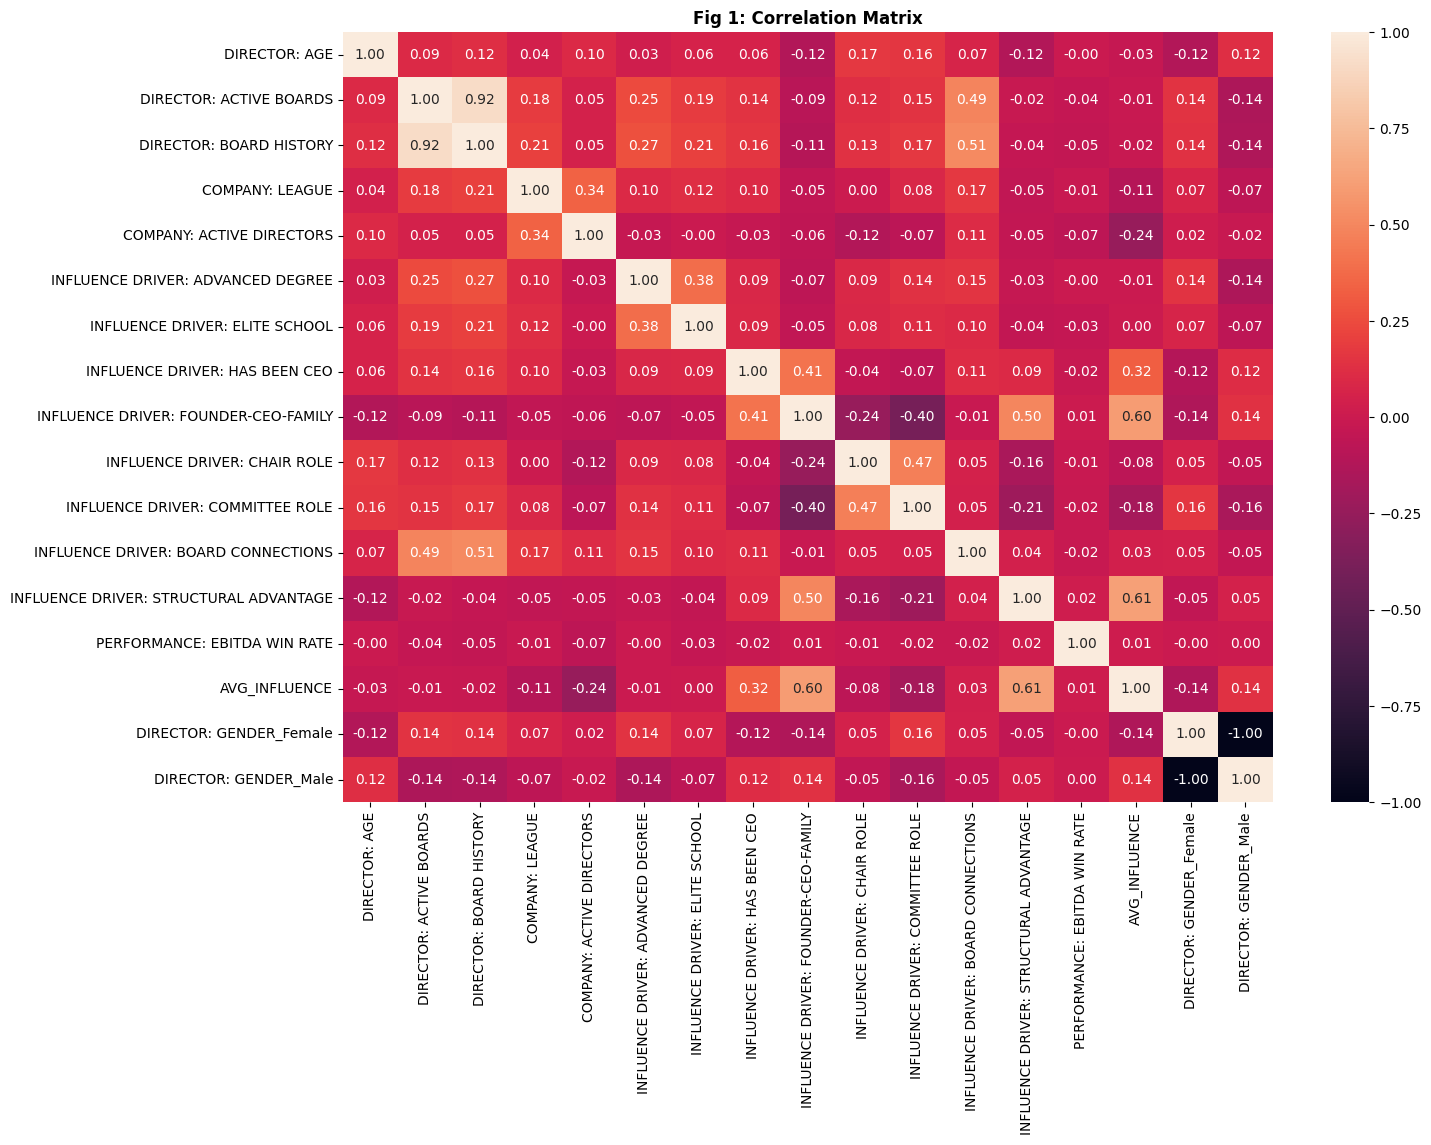

In [84]:
plt.figure(figsize=(15,10))
influence_corr = win_rate_df.corr()
sns.heatmap(influence_corr, annot=True, fmt='.2f')
plt.title('Fig 1: Correlation Matrix', fontweight='bold')

In [85]:
cols = ['DIRECTOR: AGE', 'DIRECTOR: ACTIVE BOARDS', 'DIRECTOR: BOARD HISTORY','COMPANY: LEAGUE','COMPANY: ACTIVE DIRECTORS',
       'INFLUENCE DRIVER: ADVANCED DEGREE', 'INFLUENCE DRIVER: ELITE SCHOOL',
       'INFLUENCE DRIVER: HAS BEEN CEO', 'INFLUENCE DRIVER: FOUNDER-CEO-FAMILY', 'INFLUENCE DRIVER: CHAIR ROLE',
       'INFLUENCE DRIVER: COMMITTEE ROLE', 'INFLUENCE DRIVER: BOARD CONNECTIONS',
       'INFLUENCE DRIVER: STRUCTURAL ADVANTAGE','AVG_INFLUENCE', 'DIRECTOR: GENDER_Female', 'DIRECTOR: GENDER_Male']
x=win_rate_df[cols]
y=win_rate_df['PERFORMANCE: EBITDA WIN RATE']

In [86]:
x= sm.add_constant(x)

model= sm.OLS(y, x).fit()
pred = model.predict(x)

print(model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     PERFORMANCE: EBITDA WIN RATE   R-squared:                       0.010
Model:                                      OLS   Adj. R-squared:                  0.009
Method:                           Least Squares   F-statistic:                     31.68
Date:                          Mon, 19 Jun 2023   Prob (F-statistic):           2.92e-91
Time:                                  18:57:34   Log-Likelihood:                -4925.9
No. Observations:                         48497   AIC:                             9884.
Df Residuals:                             48481   BIC:                         1.002e+04
Df Model:                                    15                                         
Covariance Type:                      nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
---

<Axes: xlabel='AVG_INFLUENCE', ylabel='PERFORMANCE: EBITDA WIN RATE'>

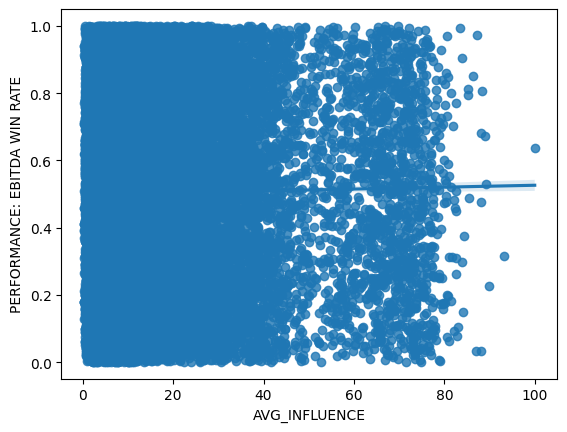

In [88]:
sns.regplot(data= win_rate_df, y= 'PERFORMANCE: EBITDA WIN RATE', x= 'AVG_INFLUENCE')

## Done

In [13]:
cleaned_dir_comp.select_dtypes(include= object).describe()

,DIRECTOR: NAME,DIRECTOR: GENDER,COMPANY: NAME,COMPANY: TICKER,COMPANY: DOMICILE,COMPANY: SECTOR,PERFORMANCE: WIN RATE,PERFORMANCE: EBITDA WIN RATE,PERFORMANCE: TSR WIN RATE,PERFORMANCE: CARBON INTENSITY WIN RATE,PERFORMANCE: CONTROVERSY WIN RATE
count,86531,86531,86531,86468,86531,86025,86531,86531,86531,86531,86531
unique,70156,2,9529,8956,67,11,996,1002,989,1002,932
top,Wei Zhang,Male,"Banco Comercial Portugues, S.A.",SOL,US,Industrials,Unrated,Unrated,Unrated,Unrated,1
freq,13,66006,29,44,25040,13350,25555,38026,43446,46093,41097


In [16]:
graph_cols = ['COMPANY: SECTOR', 'INFLUENCE DRIVER: ADVANCED DEGREE', 'INFLUENCE DRIVER: ELITE SCHOOL', 'INFLUENCE DRIVER: HAS BEEN CEO',
       'INFLUENCE DRIVER: FOUNDER-CEO-FAMILY', 'INFLUENCE DRIVER: CHAIR ROLE',
       'INFLUENCE DRIVER: COMMITTEE ROLE', 'INFLUENCE DRIVER: BOARD CONNECTIONS', 'INFLUENCE DRIVER: STRUCTURAL ADVANTAGE']
df = cleaned_dir_comp[graph_cols]

In [17]:
df['COMPANY: SECTOR'].unique()

array(['Consumer Discretionary', 'Communication Services', 'Health Care',
       'Consumer Staples', 'Financials', 'Materials',
       'Information Technology', 'Industrials', 'Energy', 'Real Estate',
       'Utilities', nan], dtype=object)

In [73]:
cleaned_df['COMPANY: SECTOR'].value_counts()

Industrials               13350
Financials                12976
Consumer Discretionary    10335
Information Technology    10254
Health Care                9170
Materials                  7979
Consumer Staples           5787
Real Estate                5674
Communication Services     4138
Utilities                  3197
Energy                     3165
Name: COMPANY: SECTOR, dtype: int64

In [27]:
cleaned_df = df[~df['COMPANY: SECTOR'].isnull()].copy()

In [19]:
cleaned_df = cleaned_df[cleaned_df['COMPANY: SECTOR'].isin(['Industrials', 'Financials','Consumer Discretionary', 'Information Technology', 'Health Care'])]
#, 'Consumer Discretionary', 'Information Technology', 'Health Care'

In [82]:
cleaned_df = cleaned_df.set_index('COMPANY: SECTOR')

In [28]:
x_df = cleaned_df.copy()

In [29]:
x_df

,COMPANY: SECTOR,INFLUENCE DRIVER: ADVANCED DEGREE,INFLUENCE DRIVER: ELITE SCHOOL,INFLUENCE DRIVER: HAS BEEN CEO,INFLUENCE DRIVER: FOUNDER-CEO-FAMILY,INFLUENCE DRIVER: CHAIR ROLE,INFLUENCE DRIVER: COMMITTEE ROLE,INFLUENCE DRIVER: BOARD CONNECTIONS,INFLUENCE DRIVER: STRUCTURAL ADVANTAGE
0,Consumer Discretionary,0,0,1,0,0,0,0,0
1,Consumer Discretionary,1,0,1,0,1,1,0,0
2,Consumer Discretionary,0,0,1,1,0,0,0,1
3,Consumer Discretionary,0,0,0,0,0,1,0,0
4,Consumer Discretionary,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...
86759,Consumer Staples,1,0,1,1,0,0,0,0
86768,Health Care,1,0,1,0,1,1,0,0
86769,Health Care,0,0,1,0,1,1,0,0
86770,Health Care,1,0,1,0,1,1,0,0


In [30]:
x_df = x_df.groupby('COMPANY: SECTOR').agg(
    Advanced_Degree = ('INFLUENCE DRIVER: ELITE SCHOOL','sum'),
    Elite_School = ('INFLUENCE DRIVER: HAS BEEN CEO','sum'),
    Been_CEO = ('INFLUENCE DRIVER: FOUNDER-CEO-FAMILY','sum'),
    Founder_CEO_Family = ('INFLUENCE DRIVER: CHAIR ROLE','sum'),
    Chair_Role = ('INFLUENCE DRIVER: COMMITTEE ROLE','sum'),
    Committee_Role = ('INFLUENCE DRIVER: BOARD CONNECTIONS','sum'),
    Board_Connection = ('INFLUENCE DRIVER: BOARD CONNECTIONS','sum'),
    Structural_Advantage = ('INFLUENCE DRIVER: STRUCTURAL ADVANTAGE','sum')
)

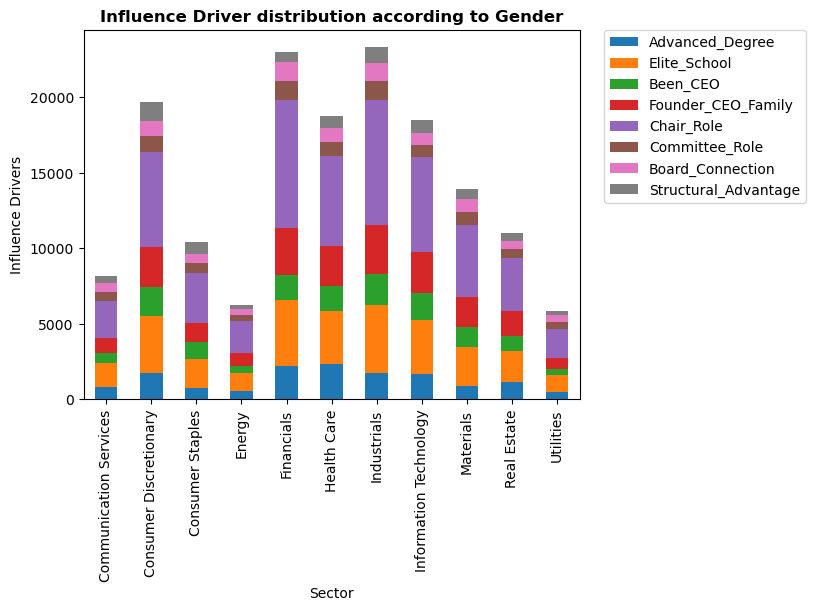

: 

In [32]:
x_df.plot(kind='bar', stacked=True)
plt.title('Influence Driver distribution according to Gender', fontweight= 'bold')
plt.xlabel('Sector')
plt.ylabel('Influence Drivers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Text(0.5, 1.0, 'Fig 1: Correlation Matrix')

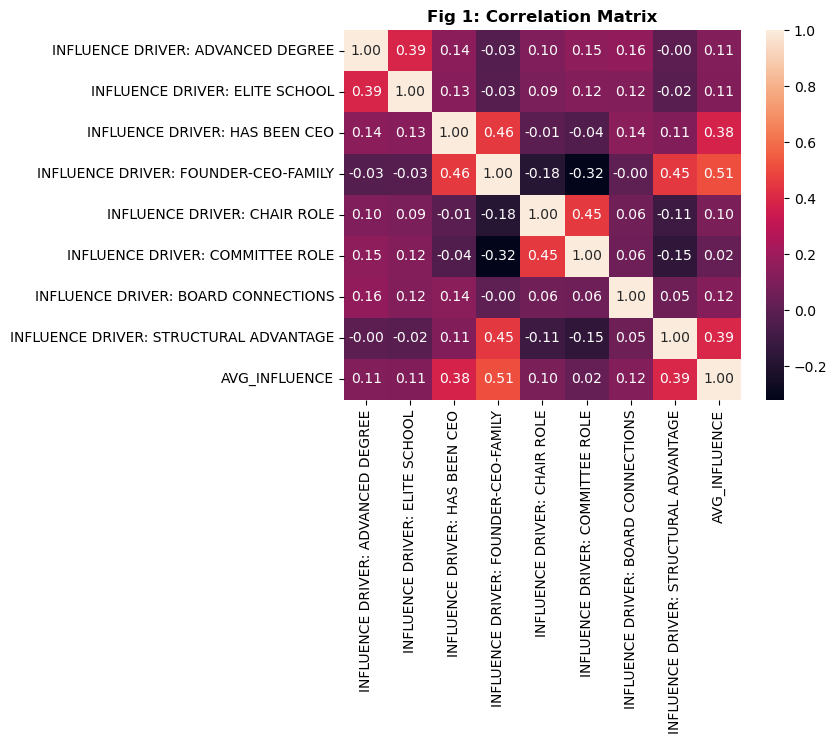

In [32]:
influence_corr = cleaned_dir_comp[cols+['AVG_INFLUENCE']].corr(method='spearman')
sns.heatmap(influence_corr, annot=True, fmt='.2f')
plt.title('Fig 1: Correlation Matrix', fontweight='bold')

<AxesSubplot:xlabel='INFLUENCE DRIVER: ADVANCED DEGREE', ylabel='AVG_INFLUENCE'>

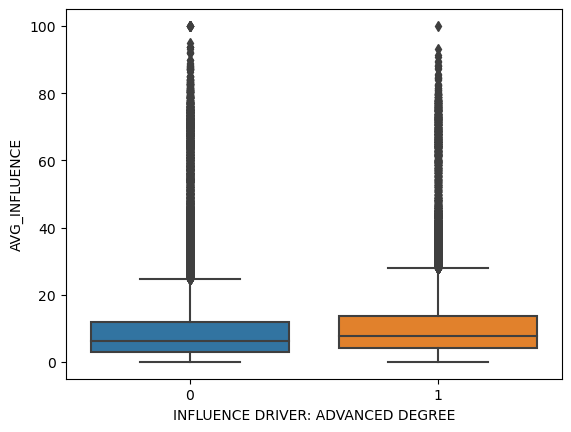

In [16]:
sns.boxplot( data=cleaned_dir_comp, x='INFLUENCE DRIVER: ADVANCED DEGREE', y='AVG_INFLUENCE')

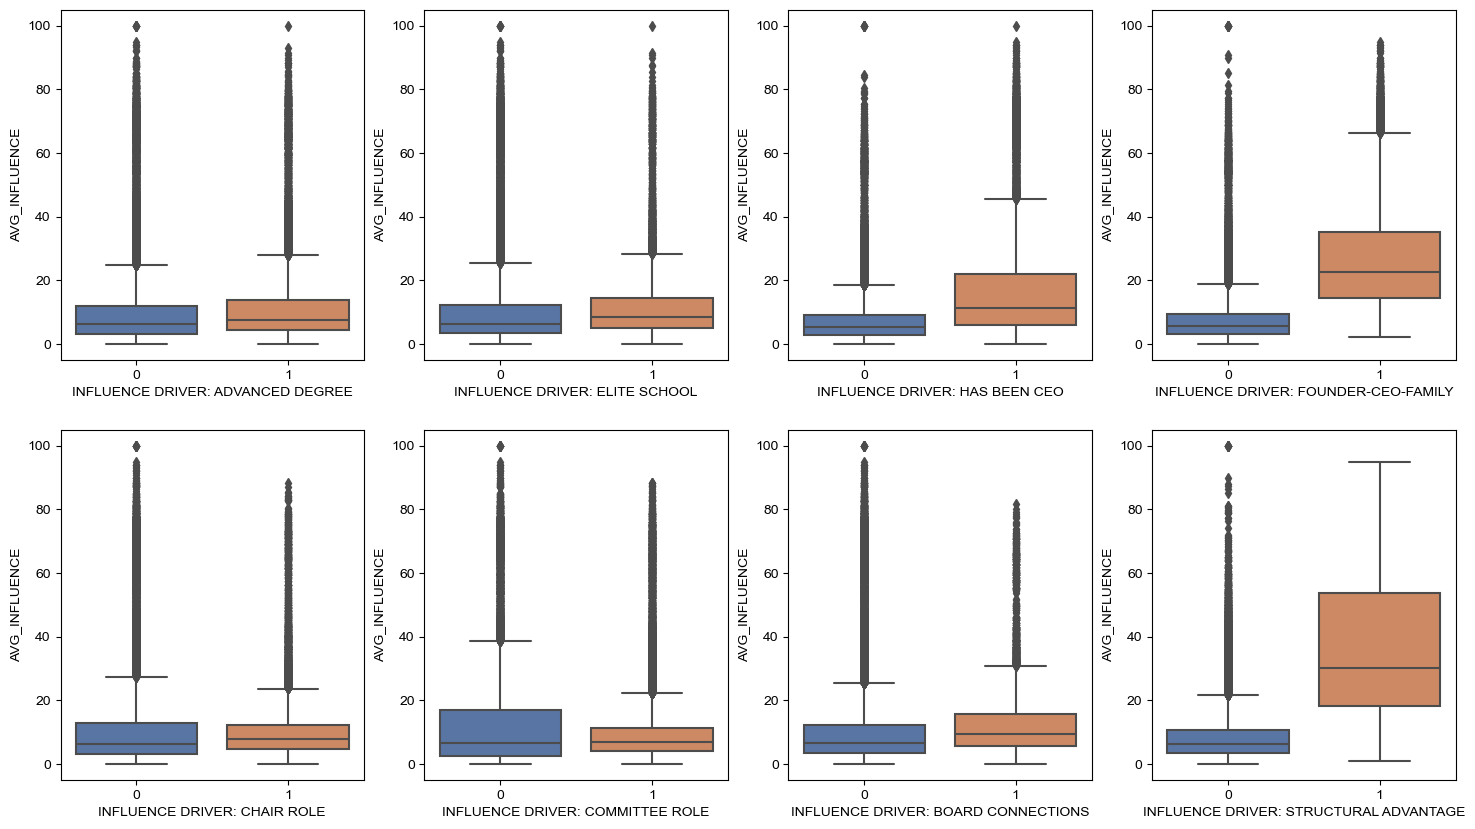

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
sns.set(font_scale = 1)
plt.rcParams['axes.labelsize'] = 1
# fig.suptitle('Influence Driver comparison over the Average Influence of the Directors', fontweight = 'bold', fontsize=20)

sns.boxplot(ax=axes[0, 0], data=cleaned_dir_comp, x='INFLUENCE DRIVER: ADVANCED DEGREE', y='AVG_INFLUENCE')
sns.boxplot(ax=axes[0, 1], data=cleaned_dir_comp, x='INFLUENCE DRIVER: ELITE SCHOOL', y='AVG_INFLUENCE')
sns.boxplot(ax=axes[0, 2], data=cleaned_dir_comp, x='INFLUENCE DRIVER: HAS BEEN CEO', y='AVG_INFLUENCE')
sns.boxplot(ax=axes[0, 3], data=cleaned_dir_comp, x='INFLUENCE DRIVER: FOUNDER-CEO-FAMILY', y='AVG_INFLUENCE')
sns.boxplot(ax=axes[1, 0], data=cleaned_dir_comp, x='INFLUENCE DRIVER: CHAIR ROLE', y='AVG_INFLUENCE')
sns.boxplot(ax=axes[1, 1], data=cleaned_dir_comp, x='INFLUENCE DRIVER: COMMITTEE ROLE', y='AVG_INFLUENCE')
sns.boxplot(ax=axes[1, 2], data=cleaned_dir_comp, x='INFLUENCE DRIVER: BOARD CONNECTIONS', y='AVG_INFLUENCE')
sns.boxplot(ax=axes[1, 3], data=cleaned_dir_comp, x='INFLUENCE DRIVER: STRUCTURAL ADVANTAGE', y='AVG_INFLUENCE')
plt.show()

## Influence - Win Rate comparison

In [91]:
cleaned_dir_comp

,DIRECTOR: ID,DIRECTOR: NAME,DIRECTOR: AGE,DIRECTOR: GENDER,DIRECTOR: ACTIVE BOARDS,DIRECTOR: BOARD HISTORY,COMPANY: NAME,COMPANY: TICKER,COMPANY: DOMICILE,COMPANY: SECTOR,COMPANY: LEAGUE,COMPANY: ACTIVE DIRECTORS,COMPANY: ALL DIRECTORS,INFLUENCE: MRY,INFLUENCE:2023,INFLUENCE:2022,INFLUENCE:2021,INFLUENCE:2020,INFLUENCE:2019,INFLUENCE:2018,INFLUENCE DRIVER: ADVANCED DEGREE,INFLUENCE DRIVER: ELITE SCHOOL,INFLUENCE DRIVER: HAS BEEN CEO,INFLUENCE DRIVER: FOUNDER-CEO-FAMILY,INFLUENCE DRIVER: CHAIR ROLE,INFLUENCE DRIVER: COMMITTEE ROLE,INFLUENCE DRIVER: BOARD CONNECTIONS,INFLUENCE DRIVER: STRUCTURAL ADVANTAGE,PERFORMANCE: WIN RATE,PERFORMANCE: EBITDA WIN RATE,PERFORMANCE: TSR WIN RATE,PERFORMANCE: CARBON INTENSITY WIN RATE,PERFORMANCE: CONTROVERSY WIN RATE,AVG_INFLUENCE
0,150319,Adam Hanft,73.0,Male,2,2,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,0.3,0.3,0.3,0.2,0.2,NaN,NaN,0,0,1,0,0,0,0,0,0.000,0.000,0.000,0.000,0.0,0.25
1,554436,Celia Brown,68.0,Female,1,1,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,3.5,3.5,3.5,3.4,3.1,3.0,3.0,1,0,1,0,1,1,0,0,0.616,0.312,0.521,0.819,1.0,3.25
2,108789,Christopher McCann,61.0,Male,1,1,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,12.0,12.0,12.0,11.9,11.9,12.2,12.2,0,0,1,1,0,0,0,1,0.618,0.315,0.536,0.817,1.0,12.03
3,677135,Dina Colombo,53.0,Female,1,1,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,1.3,1.3,1.3,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0.000,0.000,0.000,0.000,0.0,1.30
4,175585,Eugene DeMark,75.0,Male,1,2,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,2.0,2.0,2.0,1.9,1.9,1.8,1.8,1,0,0,0,1,1,0,0,0.618,0.314,0.529,0.818,1.0,1.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86767,559363,Troy Cox,58.0,Male,2,2,Zymeworks Inc,ZYME,CA,NaN,1,8,9,5.6,5.6,6.0,6.0,6.7,NaN,NaN,1,0,1,0,0,1,0,0,0.000,0.000,0.000,0.000,0.0,6.08
86768,232433,Barry Michaels,72.0,Male,1,1,Zynex Inc,ZYXI,US,Health Care,1,4,4,18.2,18.2,18.2,18.2,18.2,NaN,NaN,1,0,1,0,1,1,0,0,0.807,0.692,0.690,0.806,1.0,18.20
86769,232874,Joshua Disbrow,47.0,Male,1,1,Zynex Inc,ZYXI,US,Health Care,1,4,4,16.8,16.8,16.8,16.8,16.8,NaN,NaN,0,0,1,0,1,1,0,0,0.807,0.692,0.690,0.806,1.0,16.80
86770,638372,Michael Cress,64.0,Male,1,1,Zynex Inc,ZYXI,US,Health Care,1,4,4,18.2,18.2,18.2,18.2,18.2,NaN,NaN,1,0,1,0,1,1,0,0,0.807,0.692,0.690,0.806,1.0,18.20


In [92]:
df_copy = cleaned_dir_comp.copy()
df_copy.head()

,DIRECTOR: ID,DIRECTOR: NAME,DIRECTOR: AGE,DIRECTOR: GENDER,DIRECTOR: ACTIVE BOARDS,DIRECTOR: BOARD HISTORY,COMPANY: NAME,COMPANY: TICKER,COMPANY: DOMICILE,COMPANY: SECTOR,COMPANY: LEAGUE,COMPANY: ACTIVE DIRECTORS,COMPANY: ALL DIRECTORS,INFLUENCE: MRY,INFLUENCE:2023,INFLUENCE:2022,INFLUENCE:2021,INFLUENCE:2020,INFLUENCE:2019,INFLUENCE:2018,INFLUENCE DRIVER: ADVANCED DEGREE,INFLUENCE DRIVER: ELITE SCHOOL,INFLUENCE DRIVER: HAS BEEN CEO,INFLUENCE DRIVER: FOUNDER-CEO-FAMILY,INFLUENCE DRIVER: CHAIR ROLE,INFLUENCE DRIVER: COMMITTEE ROLE,INFLUENCE DRIVER: BOARD CONNECTIONS,INFLUENCE DRIVER: STRUCTURAL ADVANTAGE,PERFORMANCE: WIN RATE,PERFORMANCE: EBITDA WIN RATE,PERFORMANCE: TSR WIN RATE,PERFORMANCE: CARBON INTENSITY WIN RATE,PERFORMANCE: CONTROVERSY WIN RATE,AVG_INFLUENCE
0,150319,Adam Hanft,73.0,Male,2,2,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,0.3,0.3,0.3,0.2,0.2,NaN,NaN,0,0,1,0,0,0,0,0,0.000,0.000,0.000,0.000,0.0,0.25
1,554436,Celia Brown,68.0,Female,1,1,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,3.5,3.5,3.5,3.4,3.1,3.0,3.0,1,0,1,0,1,1,0,0,0.616,0.312,0.521,0.819,1.0,3.25
2,108789,Christopher McCann,61.0,Male,1,1,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,12.0,12.0,12.0,11.9,11.9,12.2,12.2,0,0,1,1,0,0,0,1,0.618,0.315,0.536,0.817,1.0,12.03
3,677135,Dina Colombo,53.0,Female,1,1,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,1.3,1.3,1.3,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0.000,0.000,0.000,0.000,0.0,1.30
4,175585,Eugene DeMark,75.0,Male,1,2,"1-800-FLOWERS.COM, INC.",FLWS,US,Consumer Discretionary,1,11,13,2.0,2.0,2.0,1.9,1.9,1.8,1.8,1,0,0,0,1,1,0,0,0.618,0.314,0.529,0.818,1.0,1.90


Text(0.5, 0.98, 'Fig. 4: Average Influence compared by Gender (2018 - 2023)')

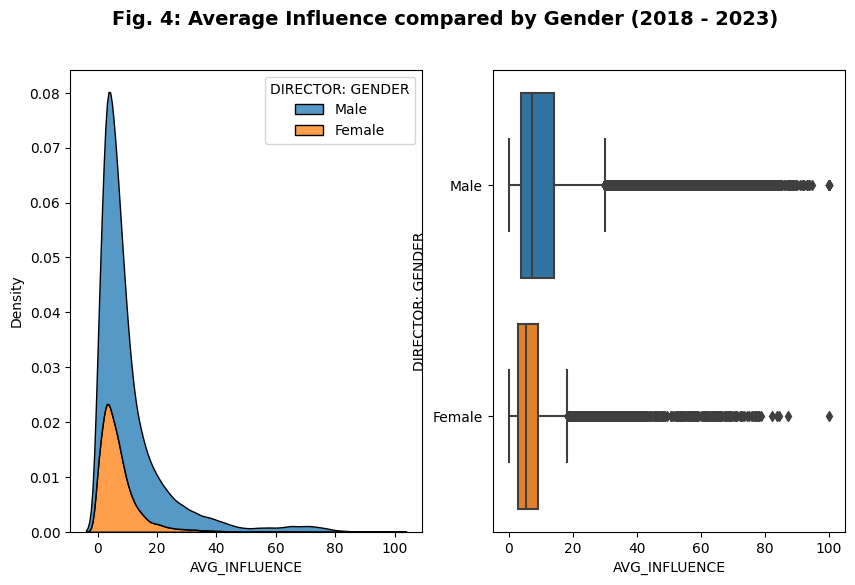

In [196]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.kdeplot(ax=axes[0], data=df_copy, x="AVG_INFLUENCE", hue="DIRECTOR: GENDER", multiple="stack")
sns.boxplot(ax=axes[1], data=df_copy, y= 'DIRECTOR: GENDER', x= 'AVG_INFLUENCE')
plt.suptitle('Fig. 4: Average Influence compared by Gender (2018 - 2023)', fontweight='bold', fontsize=14)

In [100]:
df_copy.columns

Index(['DIRECTOR: ID', 'DIRECTOR: NAME', 'DIRECTOR: AGE', 'DIRECTOR: GENDER',
       'DIRECTOR: ACTIVE BOARDS', 'DIRECTOR: BOARD HISTORY', 'COMPANY: NAME',
       'COMPANY: TICKER', 'COMPANY: DOMICILE', 'COMPANY: SECTOR',
       'COMPANY: LEAGUE', 'COMPANY: ACTIVE DIRECTORS',
       'COMPANY: ALL DIRECTORS', 'INFLUENCE: MRY', 'INFLUENCE:2023',
       'INFLUENCE:2022', 'INFLUENCE:2021', 'INFLUENCE:2020', 'INFLUENCE:2019',
       'INFLUENCE:2018', 'INFLUENCE DRIVER: ADVANCED DEGREE',
       'INFLUENCE DRIVER: ELITE SCHOOL', 'INFLUENCE DRIVER: HAS BEEN CEO',
       'INFLUENCE DRIVER: FOUNDER-CEO-FAMILY', 'INFLUENCE DRIVER: CHAIR ROLE',
       'INFLUENCE DRIVER: COMMITTEE ROLE',
       'INFLUENCE DRIVER: BOARD CONNECTIONS',
       'INFLUENCE DRIVER: STRUCTURAL ADVANTAGE', 'PERFORMANCE: WIN RATE',
       'PERFORMANCE: EBITDA WIN RATE', 'PERFORMANCE: TSR WIN RATE',
       'PERFORMANCE: CARBON INTENSITY WIN RATE',
       'PERFORMANCE: CONTROVERSY WIN RATE', 'AVG_INFLUENCE'],
      dtype='obje

In [128]:
df1 = df_copy[['DIRECTOR: AGE','DIRECTOR: GENDER','DIRECTOR: ACTIVE BOARDS', 'DIRECTOR: BOARD HISTORY','PERFORMANCE: EBITDA WIN RATE',
               'COMPANY: LEAGUE','COMPANY: ACTIVE DIRECTORS','AVG_INFLUENCE']].copy()

In [129]:
df1 = pd.get_dummies(df1, columns=['DIRECTOR: GENDER'])
df1.head()

,DIRECTOR: AGE,DIRECTOR: ACTIVE BOARDS,DIRECTOR: BOARD HISTORY,PERFORMANCE: EBITDA WIN RATE,COMPANY: LEAGUE,COMPANY: ACTIVE DIRECTORS,AVG_INFLUENCE,DIRECTOR: GENDER_Female,DIRECTOR: GENDER_Male
0,73.0,2,2,0.000,1,11,0.25,0,1
1,68.0,1,1,0.312,1,11,3.25,1,0
2,61.0,1,1,0.315,1,11,12.03,0,1
3,53.0,1,1,0.000,1,11,1.30,1,0
4,75.0,1,2,0.314,1,11,1.90,0,1


Text(0.5, 1.0, 'Fig. 6: Positive relationship found between Average Influence and EBITDA Win Rate')

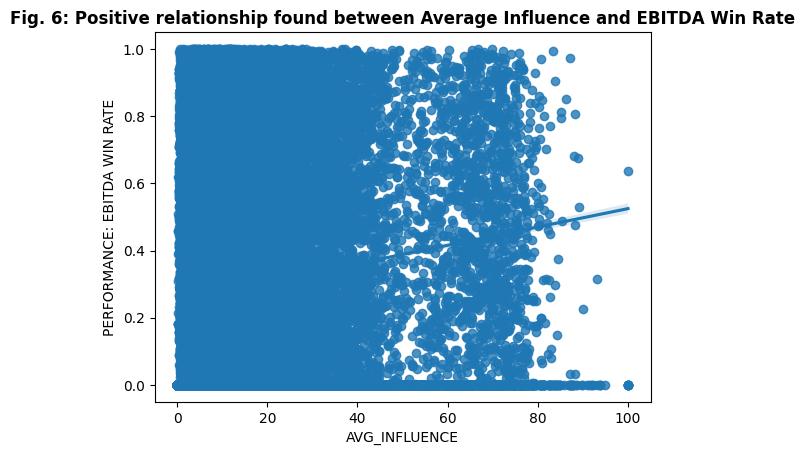

In [197]:
sns.regplot( data=df1, x='AVG_INFLUENCE', y='PERFORMANCE: EBITDA WIN RATE')
plt.title('Fig. 6: Positive relationship found between Average Influence and EBITDA Win Rate', fontweight='bold')

In [148]:
x= df1.drop(['PERFORMANCE: EBITDA WIN RATE'], axis=1)
y= df1['PERFORMANCE: EBITDA WIN RATE']

Text(0.5, 1.0, 'Fig 8: Correlation Matrix')

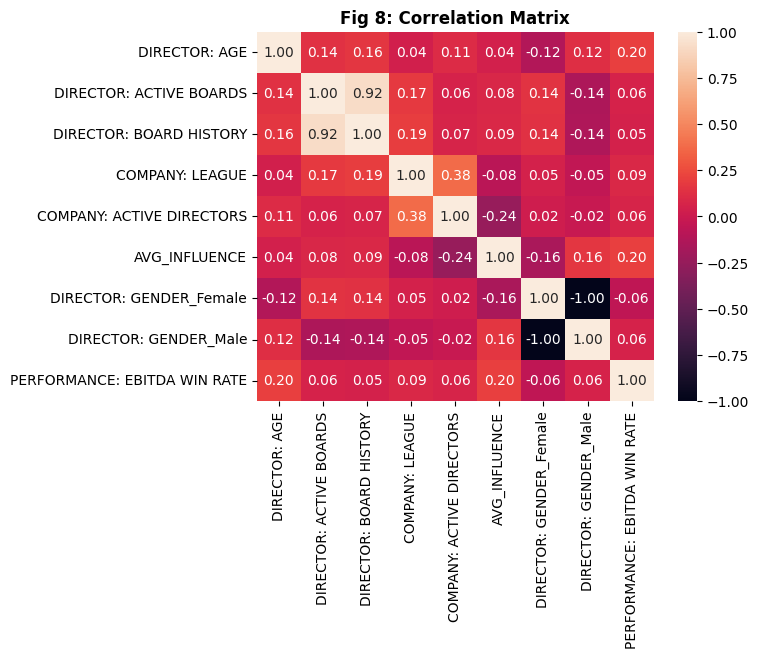

In [199]:
# Correlation Matrix
influence_corr = df1[x.columns.to_list()+['PERFORMANCE: EBITDA WIN RATE']].corr(method='spearman')
sns.heatmap(influence_corr, annot=True, fmt='.2f')
plt.title('Fig 8: Correlation Matrix', fontweight='bold')

In [162]:
# Performing Linear Regression
x = sm.add_constant(x)

model= sm.OLS(y, x).fit()

print(model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     PERFORMANCE: EBITDA WIN RATE   R-squared:                       0.049
Model:                                      OLS   Adj. R-squared:                  0.049
Method:                           Least Squares   F-statistic:                     638.1
Date:                          Mon, 19 Jun 2023   Prob (F-statistic):               0.00
Time:                                  21:34:04   Log-Likelihood:                -22065.
No. Observations:                         86531   AIC:                         4.415e+04
Df Residuals:                             86523   BIC:                         4.422e+04
Df Model:                                     7                                         
Covariance Type:                      nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------

### Random Forest Regressor

In [164]:
# Dropping the constant column
x = x.drop('const', axis=1)

In [168]:
# Splits a dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [169]:
# Scaling Linear Regression input Data
scale = StandardScaler()
var_names = x_train.columns
scaled_data = scale.fit_transform(x_train)
x_scaled_rf = pd.DataFrame(scaled_data, columns=var_names)

In [171]:
# Performing Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100)

rf_reg.fit(x_train, y_train)

y_pred = rf_reg.predict(x_test)


In [189]:
# Extracting Feature Importance of Random Forest Regressor
rf_feat_imp_df = pd.DataFrame({'feature':rf_reg.feature_names_in_, 'Importance':rf_reg.feature_importances_})
rf_feat_imp_df.sort_values(by='Importance', ascending=True, inplace=True)
rf_feat_imp_df

,feature,Importance
6,DIRECTOR: GENDER_Female,0.018601
7,DIRECTOR: GENDER_Male,0.018772
1,DIRECTOR: ACTIVE BOARDS,0.034767
3,COMPANY: LEAGUE,0.043468
2,DIRECTOR: BOARD HISTORY,0.043922
4,COMPANY: ACTIVE DIRECTORS,0.151913
0,DIRECTOR: AGE,0.183570
5,AVG_INFLUENCE,0.504987


Text(0.5, 1.0, 'Fig. 10: Random Forest Feature Importance')

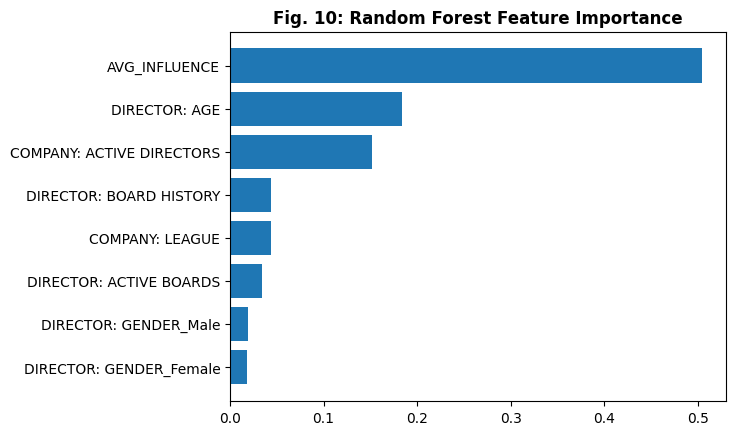

In [201]:
# Plot the feature importance of a Random Forest model.
plt.barh(rf_feat_imp_df.feature, rf_feat_imp_df.Importance)
plt.title('Fig. 10: Random Forest Feature Importance', fontweight='bold')